# Assignment 5(due on 12/20)

## Student:郑炜（12332242），Gtihub：fytctctvy

## 批改人：吴昊天

## 得分：52/40

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import math

In [15]:
# 导入数据
CO2 = pd.read_csv("global.1751_2008.csv")

[ 4.82316522e-18  2.43954472e-02 -1.12313831e+02]


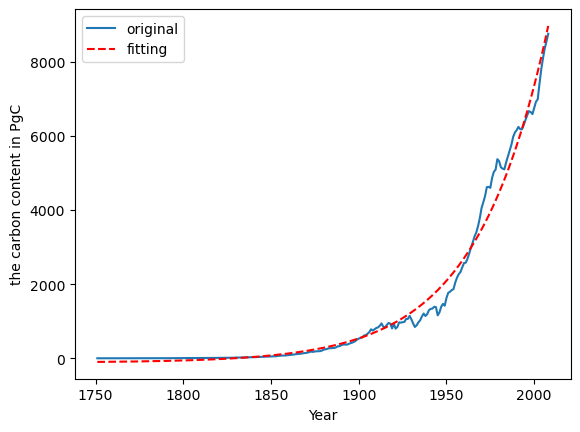

In [16]:
# # 1.1
# 定义一个指数函数
def r_func(x, a, b, c):
    return a * np.exp(b * x) + c

# 没加maxfev时，报错提示：Optimal parameters not found: Number of calls to function has reached maxfev = 800.
# 为了解决问题，参考：https://blog.csdn.net/Jacktuo/article/details/120682582
# 发现改变最大迭代次数后，还是报错，为了减少计算量，用p0来设置参数的初始值，参考：https://zhuanlan.zhihu.com/p/144353126
popt,pcov = curve_fit(r_func, CO2['Year'], CO2['Total'],maxfev=1500, p0=[1,0,1])
# 输出拟合系数a,b,c
print(popt)
y_fit= [r_func(i, popt[0], popt[1], popt[2]) for i in CO2['Year']]

#输出原曲线和拟合曲线
plt.plot(CO2['Year'], CO2['Total'],label='original')
plt.plot(CO2['Year'], y_fit,'r--',label='fitting')
plt.legend(loc=2)
plt.xlabel('Year');plt.ylabel('the carbon content in PgC')
plt.show()
# 注意这里单位为百万公吨（1 Tg C=0.001 Pg C）

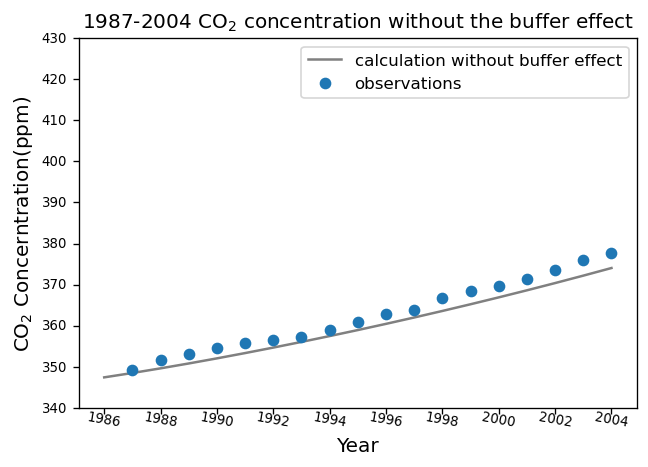

In [17]:
#排放速率r=a*e^(bx)+c, r'=a*b*e^(bx)
a=popt[0]
b=popt[1]
c=popt[2]
# 从拟合的函数选取1987-2004时间段
x1=np.arange(1986,2005)
# r1为拟合每年产生的多少百万公吨碳
r1=r_func(x1, a,b,c)
# 初始条件，N1和N2单位均为Tg C
k12=105/740
k21=102/900
N1=740*1000
N2=900*1000
y0=[N1,N2,r1[0]]

# 函数定义了一个包含三个微分方程的微分方程组,得到N1，N2 和 r 随时间的变化率：dN1/dt，N2/dt 和 dr/dt(即γ)
def pend(y,x1,k12,k21):
    N1, N2, r1 = y
    return [-k12*N1+k21*N2+r1,k12*N1-k21*N2, b*(r1-c)]

# 对以上微分方程积分，得到的函数sol的三列分别为N1，N2 和 r
sol=odeint(pend, y0,x1, args=(k12,k21))
# 文章中说1986年的740 PgC对应的浓度时347 ppm(文中说将PgC单位数据除以2.13就得到 ppm)，
# 因此按照这个系数将得到的大气浓度转化为 ppm单位
sol_N1 = sol[:,0]/2.13/1000

# 作图，画拟合曲线
plt.figure(figsize=(6,4),dpi=120)
plt.plot(x1, sol_N1, color='gray', label='calculation without buffer effect')
# 画实际观测图，仅选取1987-2004时间段的数据
observation = pd.read_csv("co2_annmean_mlo.csv")
observation_1=observation.iloc[28:46,]
plt.plot(observation_1['year'],observation_1['mean'],"o",label='observations')

plt.yticks(ticks=np.arange(340,440,10), fontsize=8, rotation=0, ha='right', va='center')
plt.xticks(ticks=np.arange(1986,2005,2), fontsize=8, rotation=-10, ha='center', va='center')
plt.legend()
plt.xlabel('Year',fontsize=12)
plt.ylabel('CO$_2$ Concerntration(ppm)',fontsize=12)
plt.title('1987-2004 CO$_2$ concentration without the buffer effect',fontsize=12)
plt.show()

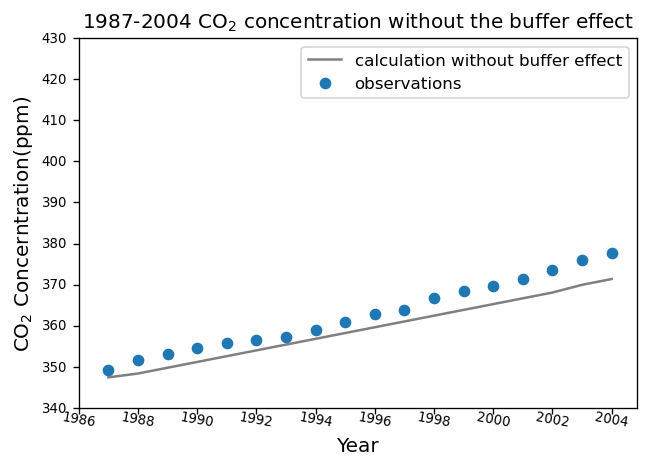

In [18]:
# 感觉计算值和观测值不像文中重合，因此采用另一种方式计算
# 选取到1987-2004的数据，并将单位PgC换算成百万公吨
r1 = np.loadtxt("global.1751_2008.csv", delimiter=",", skiprows = 237)[0:-4,1]/1000
# 定义参数
x1 = np.arange(1987,2005)
k12 = 105/740
k21 = 102/900
N1_pend_1 = np.empty_like(x1)
N2_pend_1 = np.empty_like(x1)

# 函数定义了一个包含两个微分方程的微分方程组,得到N1，N2 随时间的变化率
def pend_1(N,x1,r1):
    N1,N2 = N
    dN1dt = -k12 * N1 + k21 * N2 + r1
    dN2dt = k12 * N1 - k21 * N2
    return [dN1dt, dN2dt]

# 设置初始值
N0 = [740, 900]
N1_pend_1[0],N2_pend_1[0] = N0

# 对以上微分方程积分，2004-1987+1=18
for i in range(1,18):
    dx = [0,1]
    N = odeint(pend_1,N0,dx,args=(r1[i-1],))
    N1_pend_1[i] = N[1][0]
    N2_pend_1[i] = N[1][1]
    N0 = N[1]
    
# 单位换算成ppm
sol_N11 = N1_pend_1/2.13

# 作图，画拟合曲线
plt.figure(figsize=(6,4),dpi=120)
plt.plot(x1, sol_N11, color='gray', label='calculation without buffer effect')

# 画实际观测图，仅选取1987-2004时间段的数据
plt.plot(observation_1['year'],observation_1['mean'],"o",label='observations')

plt.yticks(ticks=np.arange(340,440,10), fontsize=8, rotation=0, ha='right', va='center')
plt.xticks(ticks=np.arange(1986,2005,2), fontsize=8, rotation=-10, ha='center', va='center')
plt.legend()
plt.xlabel('Year',fontsize=12)
plt.ylabel('CO$_2$ Concerntration(ppm)',fontsize=12)
plt.title('1987-2004 CO$_2$ concentration without the buffer effect',fontsize=12)
plt.show()

# 观测值和计算值接近了一些（1987和1993年重合了），但还是无法完全符合文章中的图
# 但以上两种方法思路相同，只是计算方法不同也会有误差，因此与文中图片的差异可能是数据的计算误差

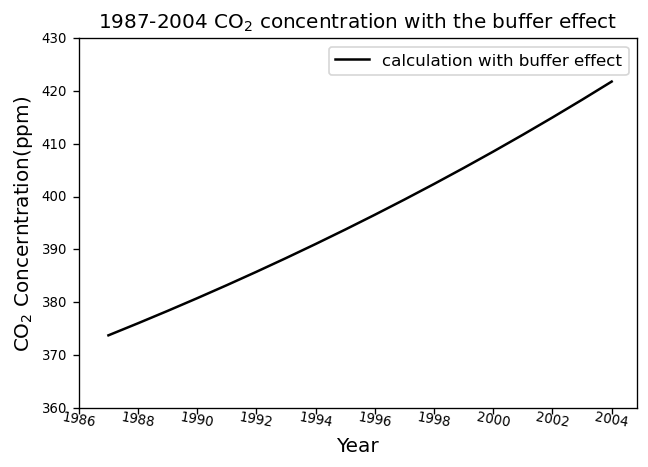

In [19]:
# 1.2

#从前工业时代开始计算（1750年）
x2=np.arange(1750,2005)
r2=r_func(x2, a,b,c)

# 初始条件
k12=105/740
k21=102/900
N1=615*1000
N2=842*1000
y0=[N1,N2,r2[0]] 

# 函数定义了一个包含三个微分方程的微分方程组,得到N1，N2 和 r 随时间的变化率：dN1/dt，N2/dt 和 dr/dt(即γ)
def pend_2(y,x2,k12,k21):
    N1,N2,r2 = y
    z = N1/1000/2.13                                  # 将大气中二氧化碳浓度转化为 ppm 
    N2_0 = 842*1000                                   # 工业化前海洋二氧化碳的初始值
    ξ = 3.69+1.86e-2*(z)-1.8e-6*(z**2)              # 缓冲因子
    return [-k12*N1+k21*(N2_0+ξ*(N2-N2_0))+r2, k12*N1-k21*(N2_0+ξ*(N2-N2_0)),b*(r2-c)]
 
# 积分并将单位换算成 ppm
sol_1= odeint(pend_2, y0, x2, args=(k12,k21))
sol_N1_1 = sol_1/2.13/1000  

# 作图
plt.figure(figsize=(6,4),dpi=120)
plt.plot(x2[237:255],sol_N1_1[237:255,0], color='k', label='calculation with buffer effect')
         
plt.yticks(ticks=np.arange(360,440,10), fontsize=8, rotation=0, ha='right', va='center')
plt.xticks(ticks=np.arange(1986,2006,2), fontsize=8, rotation=-10, ha='center', va='center')
plt.legend()
plt.xlabel('Year',fontsize=12)
plt.ylabel('CO$_2$ Concerntration(ppm)',fontsize=12)
plt.title('1987-2004 CO$_2$ concentration with the buffer effect',fontsize=12)
plt.show()

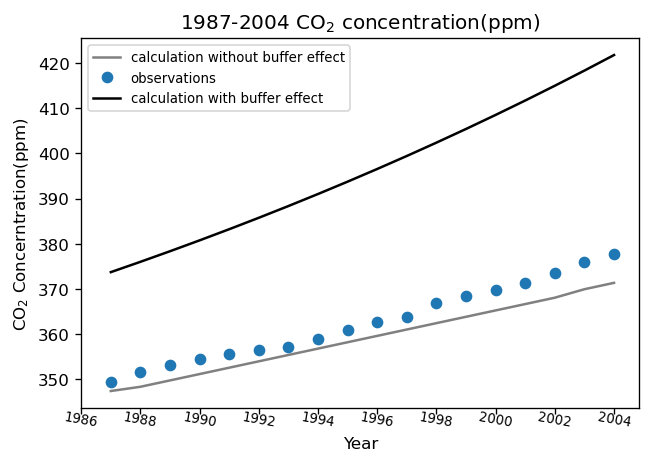

In [20]:
#1.3
plt.figure(figsize=(6,4),dpi=120)
# 对三种数据作图
plt.plot(x1, sol_N11, color='gray', label='calculation without buffer effect')
plt.plot(observation_1['year'],observation_1['mean'],"o",label='observations')
plt.plot(x2[237:255],sol_N1_1[237:255,0], color='k', label='calculation with buffer effect')

#调整作图参数
plt.xticks(ticks=np.arange(1986,2006,2), fontsize=8, rotation=-10, ha='center', va='center')
plt.legend(loc='best',fontsize=8)
plt.xlabel('Year');plt.ylabel('CO$_2$ Concerntration(ppm)')
plt.title('1987-2004 CO$_2$ concentration(ppm)',fontsize=12)
plt.show()

In [21]:
# Bonus
seven_box=pd.read_csv("Global_land-use_flux-1850_2005.csv")
# 新建dataframe.将全球土地变化引起的二氧化碳变化数据提取出来
# 并按照文中给出的1750年对应的0.2 PgC数据转化为百万公吨插入表格第一行
df = pd.DataFrame()
df['Year'] = seven_box['Year']
df['Global'] = seven_box['Global']
row=['1750','200']
# df.iloc[0]=row
df = df.astype(int)
df

,Year,Global
0,1850,500
1,1851,492
2,1852,548
3,1853,546
4,1854,544
...,...,...
151,2001,1385
152,2002,1517
153,2003,1513
154,2004,1534


[ 4.82316522e-18  2.43954472e-02 -1.12313831e+02]


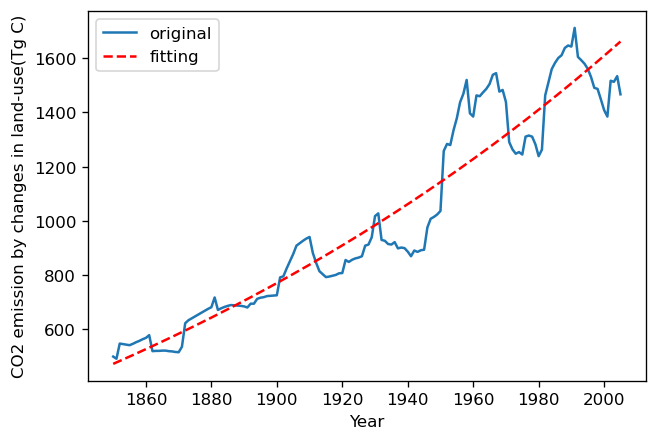

In [22]:
# 定义一个指数函数（土地利用变化对大气的排放率）
def δ_func(x, a, b, c):
    return a * np.exp(b * x) + c

popt1,pcov = curve_fit(δ_func, df['Year'], df['Global'], p0=[1,0,1], maxfev=2000)
y_fit= [δ_func(i, popt1[0], popt1[1], popt1[2]) for i in df['Year']]

# 作图
#输出原曲线和拟合曲线
plt.figure(figsize=(6,4),dpi=120)
plt.plot(df['Year'], df['Global'],label='original')
plt.plot(df['Year'], y_fit,'r--',label='fitting')
plt.legend(loc=2)
plt.xlabel('Year')
plt.ylabel('CO2 emission by changes in land-use(Tg C)')

#输出拟合得到的a1,b1,c1值
print(popt)

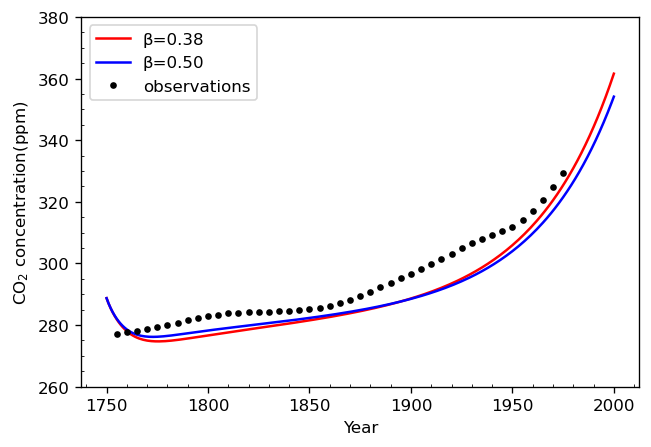

In [23]:
a1 = popt1[0]
b1 = popt1[1]
c1 = popt1[2]

# 输入系数和各参数初始值
N02 = 821
k12 = 60/615
k21 = 60/842
k23 = 9/842
k24 = 43/842
k32 = 52/9744
k34 = 162/9744
k43 = 205/26280
k45 = 0.2/26280
k51 = 0.2/90000000
k67 = 62/731
k71 = 62/1328

N1=615*1000
N2=842*1000
N3=9744*1000
N4=26280*1000
N5=90000000*1000
N6=731*1000
N7=1238*1000

# 选取1750-2000年
x3=np.arange(1750,2001)
r3=r_func(x3,a,b,c)
δ=δ_func(x3,a1,b1,c1)                         # δ是土地利用变化对大气的排放率
y0=[N1,N2,N3,N4,N5,N6,N7,r3[0],δ[0]]

#β=0.38
def pend_3(y,x3):
    N1,N2,N3,N4,N5,N6,N7,r3,δ = y
    z =N1/1000/2.13                             # 将大气中二氧化碳浓度转化为 ppm    
    N2_0 = 842*1000                       
    p=N1
    p0=615*1000                                 # p为大气二氧化碳浓度，p0对应于工业化前的p值
    f0=62*1000                                  # f为净初级生产率，f0对应于工业化前的f值
    ξ = 3.69+1.86e-2*(z)-1.8e-6*(z**2)        # 缓冲因子
    f=f0*(1+0.38*math.log(p/p0,math.e))    
    dydt = [-k12*N1+k21*(N2_0+ξ*(N2-N2_0))+r3-f+δ+k51*N5+k71*N7,    # 以下是N1 到 N7的七个box和r3的二氧化碳时间变化率
            k12*N1-k21*(N2_0+ξ*(N2-N2_0))-k23*N2+k32*N3-k24*N2,
            k23*N2-k32*N3-k34*N3+k43*N4, 
            k34*N3-k43*N4+k24*N2-k45*N4,
            k45*N4-k51*N5,
            f-k67*N6-2*δ,
            k67*N6-k71*N7+δ,
            b*(r3-c),
            b1*(r3-c1)]
    return dydt

#β=0.50
def pend_4(y,x3):
    N1,N2,N3,N4,N5,N6,N7,r3,δ = y
    z =N1/1000/2.13                  
    N2_0 = 842*1000                     
    p=N1
    p0=615*1000
    f0=62*1000      
    ξ = 3.69+1.86e-2*(z)-1.8e-6*(z**2)  
    f=f0*(1+0.50*math.log( p/p0,math.e))
    dydt = [-k12*N1+k21*(N2_0+ξ*(N2-N2_0))+r3-f+δ+k51*N5+k71*N7,
            k12*N1-k21*(N2_0+ξ*(N2-N2_0))-k23*N2+k32*N3-k24*N2,
            k23*N2-k32*N3-k34*N3+k43*N4, 
            k34*N3-k43*N4+k24*N2-k45*N4,
            k45*N4-k51*N5,
            f-k67*N6-2*δ,
            k67*N6-k71*N7+δ,
            b*(r3-c),
            b1*(r3-c1)]
    return dydt

# 积分完将单位转化为ppm
sol3=odeint(pend_3, y0,x3)/2.13/1000 
sol4=odeint(pend_4, y0,x3)/2.13/1000

# 作图
# 画不同β值对应的积分曲线
plt.figure(figsize=(6,4),dpi=120)
axes = plt.subplot()
plt.plot(x3, sol3[:,0], 'r', label='β=0.38')
plt.plot(x3, sol4[:,0], 'b', label='β=0.50')

# 根据观测值作图
observation_2=pd.read_csv("lawdome.smoothed yr75.csv")
observation_3 = observation_2.iloc[149:195]
plt.plot(observation_3['Year'],observation_3['CO2_ppm'],"k .",label='observations')

# 显示主副刻度线
axes.minorticks_on()
plt.yticks(ticks=np.linspace(260,380,7), fontsize=10)
axes.tick_params(axis="y", which="minor", direction="in", width=0.5, length=2)
plt.xticks(ticks=np.linspace(1750,2000,6), fontsize=10)
axes.tick_params(axis="x", which="minor", direction="in", width=0.5, length=2)

plt.legend()
plt.xlabel('Year')
plt.ylabel('CO$_2$ concentration(ppm)')
plt.show()

## 基本结果正确
## 加分题结果与论文有些许差异，这里助教提供参考代码给您参考。代码来自于唐正道（12331306）同学。

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

年份: 1987, 大气中二氧化碳水平: 348.70 ppm
年份: 1988, 大气中二氧化碳水平: 350.05 ppm
年份: 1989, 大气中二氧化碳水平: 351.44 ppm
年份: 1990, 大气中二氧化碳水平: 352.80 ppm
年份: 1991, 大气中二氧化碳水平: 354.17 ppm
年份: 1992, 大气中二氧化碳水平: 355.48 ppm
年份: 1993, 大气中二氧化碳水平: 356.78 ppm
年份: 1994, 大气中二氧化碳水平: 358.12 ppm
年份: 1995, 大气中二氧化碳水平: 359.51 ppm
年份: 1996, 大气中二氧化碳水平: 360.95 ppm
年份: 1997, 大气中二氧化碳水平: 362.41 ppm
年份: 1998, 大气中二氧化碳水平: 363.86 ppm
年份: 1999, 大气中二氧化碳水平: 365.28 ppm
年份: 2000, 大气中二氧化碳水平: 366.77 ppm
年份: 2001, 大气中二氧化碳水平: 368.31 ppm
年份: 2002, 大气中二氧化碳水平: 369.87 ppm
年份: 2003, 大气中二氧化碳水平: 371.59 ppm
年份: 2004, 大气中二氧化碳水平: 373.43 ppm


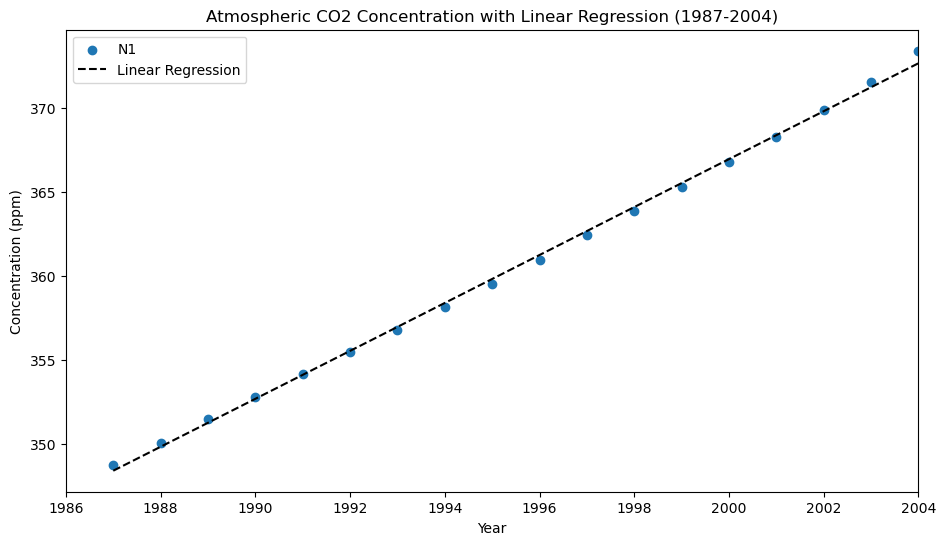

In [ ]:
#5.1
da=pd.read_csv("global.1751_2014.csv")
da_convert=da.iloc[:, :2]
da_convert_drop=da_convert.drop(0)
da_convert_drop['PGC'] = da_convert_drop['Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)'].astype(float).apply(lambda x: x * 1e12 / 1e15)
ppm = da_convert_drop[['Year', 'PGC']].loc[237:254]
a = []
N1 = 740 
N2 = 900  
k12 = 105 / 740  
k21 = 102 / 900  
num_years = len(ppm)
for i in range(num_years):
    year = ppm['Year'].iloc[i]
    gamma = ppm['PGC'].iloc[i]
    dN1_dt = -k12 * N1 + k21 * N2 + gamma
    dN2_dt = k12 * N1 - k21 * N2
    dt = 1  
    N1 += dN1_dt * dt
    N2 += dN2_dt * dt
    a.append(N1 / 2.13)
    print(f"年份: {year}, 大气中二氧化碳水平: {N1 / 2.13:.2f} ppm")
years = np.arange(1987, 2005, 1)
co2 = np.array(a).reshape(-1, 1)
X = years.reshape(-1, 1)  
Y = co2
regressor = LinearRegression()
regressor.fit(X, Y)
predicted_co2 = regressor.predict(X)
plt.figure(figsize=(11, 6))
plt.scatter(X, Y, label='N1')
plt.plot(X, predicted_co2, color='black', linestyle='--', label='Linear Regression')
plt.xlabel('Year')
plt.ylabel('Concentration (ppm)')
plt.xlim(1986, 2004)
plt.title('Atmospheric CO2 Concentration with Linear Regression (1987-2004)')
plt.legend()
plt.show()


年份: 1987, 大气中二氧化碳水平: 386.25 ppm
年份: 1988, 大气中二氧化碳水平: 379.05 ppm
年份: 1989, 大气中二氧化碳水平: 384.78 ppm
年份: 1990, 大气中二氧化碳水平: 386.37 ppm
年份: 1991, 大气中二氧化碳水平: 389.31 ppm
年份: 1992, 大气中二氧化碳水平: 391.79 ppm
年份: 1993, 大气中二氧化碳水平: 394.41 ppm
年份: 1994, 大气中二氧化碳水平: 397.03 ppm
年份: 1995, 大气中二氧化碳水平: 399.73 ppm
年份: 1996, 大气中二氧化碳水平: 402.49 ppm
年份: 1997, 大气中二氧化碳水平: 405.30 ppm
年份: 1998, 大气中二氧化碳水平: 408.11 ppm
年份: 1999, 大气中二氧化碳水平: 410.92 ppm
年份: 2000, 大气中二氧化碳水平: 413.81 ppm
年份: 2001, 大气中二氧化碳水平: 416.77 ppm
年份: 2002, 大气中二氧化碳水平: 419.77 ppm
年份: 2003, 大气中二氧化碳水平: 422.95 ppm
年份: 2004, 大气中二氧化碳水平: 426.29 ppm


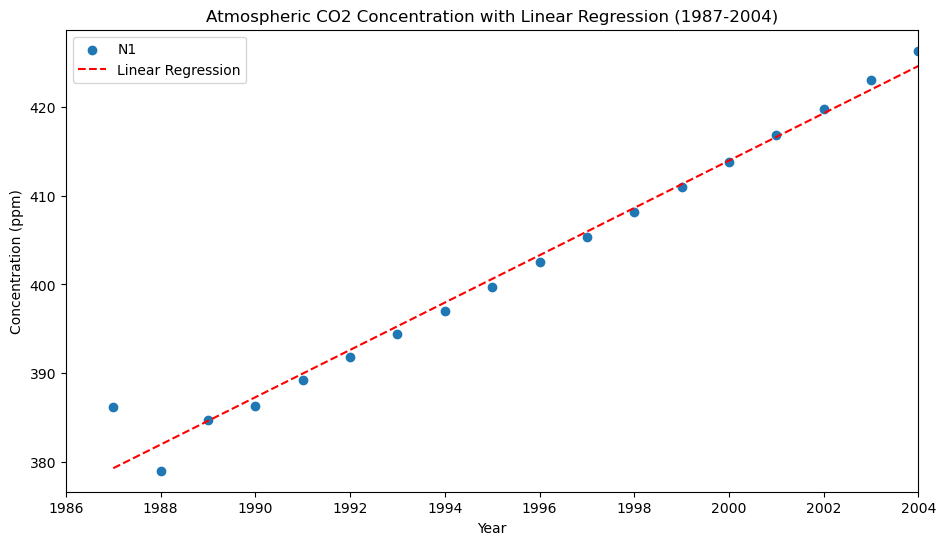

In [ ]:
#5.2
b = []
N1 = 740  
N2 = 900  
k12 = 105 / 740  
k21 = 102 / 900  
N20 = 821  
for i in range(num_years):
    year = ppm['Year'].iloc[i]
    gamma1 = ppm['PGC'].iloc[i]
    z = N1 / 2.13 
    xi = 3.69 + 1.86 * 10**(-2) * z - 1.80 * 10**(-6) * z**2
    dN1_dt = -k12 * N1 + k21 * (N20 + xi * (N2 - N20)) + gamma1
    dN2_dt = k12 * N1 - k21 * (N20 + xi * (N2 - N20))
    dt = 1  
    N1 += dN1_dt * dt
    N2 += dN2_dt * dt
    b.append(N1 / 2.13)
    print(f"年份: {year}, 大气中二氧化碳水平: {N1 / 2.13:.2f} ppm")
years = np.arange(1987, 2005, 1)
co2_2 = np.array(b).reshape(-1, 1)
X_2 = years.reshape(-1, 1)  
Y_2 = co2_2
regressor = LinearRegression()
regressor.fit(X_2, Y_2)
predicted_co2_2 = regressor.predict(X_2)
plt.figure(figsize=(11, 6))
plt.scatter(X_2, Y_2, label='N1')
plt.plot(X_2, predicted_co2_2, color='red', linestyle='--', label='Linear Regression')
plt.xlabel('Year')
plt.ylabel('Concentration (ppm)')
plt.xlim(1986, 2004)
plt.title('Atmospheric CO2 Concentration with Linear Regression (1987-2004)')
plt.legend()
plt.show()

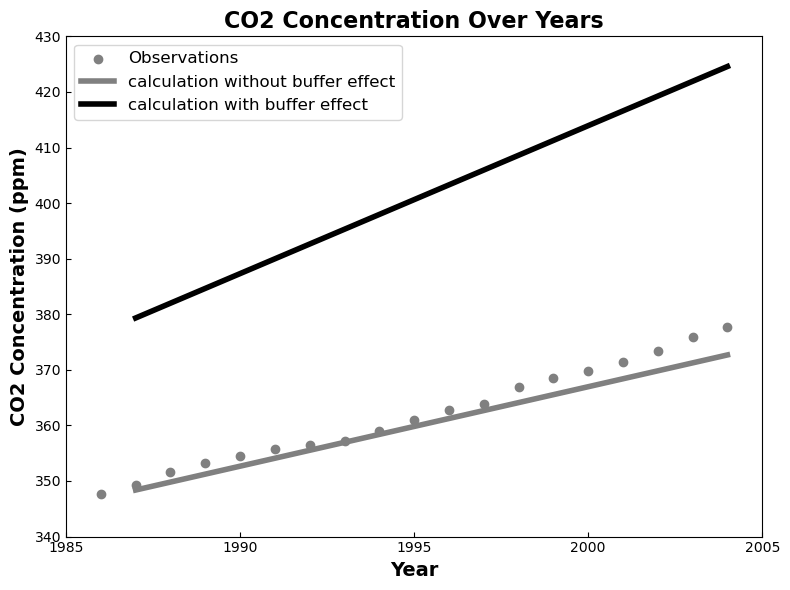

In [ ]:
#5.3
da1 = pd.read_csv("co2_annmean_mlo.csv", comment='#')
filtered_da1 = da1[(da1['year'] >= 1986) & (da1['year'] <= 2004)]
years_with_1986 = filtered_da1['year']
observations_with_1986 = filtered_da1['mean']
plt.figure(figsize=(8, 6))
plt.scatter(years_with_1986, observations_with_1986, color='grey', label='Observations')
plt.plot(X, predicted_co2, color='grey', linestyle='-', label='calculation without buffer effect', linewidth=4)
plt.plot(X_2, predicted_co2_2, color='black', linestyle='-', label='calculation with buffer effect', linewidth=4)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in', which='both')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('CO2 Concentration (ppm)', fontsize=14, fontweight='bold')
plt.title('CO2 Concentration Over Years', fontsize=16, fontweight='bold')
plt.grid(False)
plt.xticks(np.arange(1985, 2006, 5))
plt.xlim(1985, 2005)
plt.ylim(340, 430)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

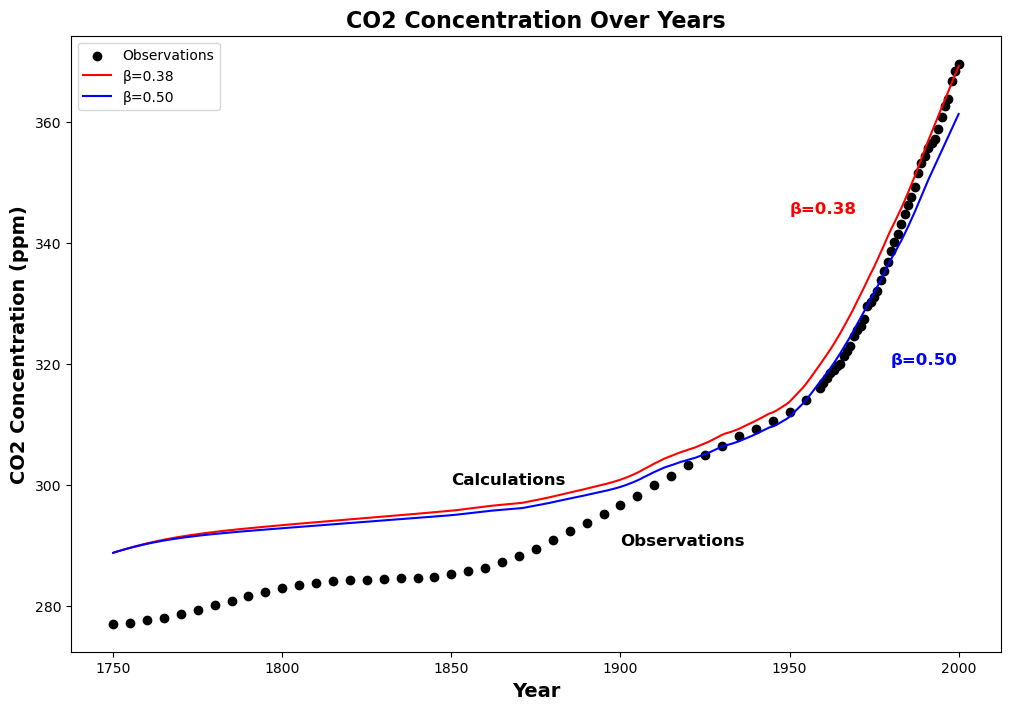

In [ ]:
#5.4
co2_observations = pd.read_csv("1750-2000CO2.csv")
land_use_data = pd.read_excel("Global_land-use_flux-1750_2005.xls")
fossil_emissions = pd.read_csv("global_1751_2016.csv")
land_use_data = land_use_data[['Year', 'Global']]
land_use_data['LandUseChange'] = land_use_data['Global'] / (1000 * 2.13)
fossil_emissions = fossil_emissions[['Year', 'Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)', 'Carbon emissions from cement production']]
fossil_emissions['FossilFuelEmissions'] = fossil_emissions.iloc[:, 1] - fossil_emissions.iloc[:, 2]
fossil_emissions['EmissionFactor'] = fossil_emissions['FossilFuelEmissions'] / (1000 * 2.13)
k12, k21, k23, k24, k32, k34, k43, k45, k51, k67, k71 = [60 / 615, 60 / 842, 9 / 842, 43 / 842, 52 / 9744, 162 / 9744, 205 / 26280, 0.2 / 26280, 0.2 / 90000000, 62 / 731, 62 / 1238]
initial_conditions = [615 / 2.13, 842 / 2.13, 9744 / 2.13, 26280 / 2.13, 90000000 / 2.13, 731 / 2.13, 1238 / 2.13]
N2_0 = 842 / 2.13
f0 = 62 / 2.13
P0 = 615 / 2.13
beta_values = [0.38, 0.5]
results = []
for beta in beta_values:
    N1, N2, N3, N4, N5, N6, N7 = initial_conditions.copy()
    atmosphere = [N1]
    for year in range(1751, 2001):
        gamma1 = fossil_emissions[fossil_emissions['Year'] == year]['EmissionFactor'].values[0]
        delta = land_use_data[land_use_data['Year'] == year]['LandUseChange'].values[0]
        xi = 3.69 + 0.0186 * N1 - 0.0000018 * N1**2
        f = f0 * (1 + beta * np.log(N1 / P0))
        dN1_dt = -k12 * N1 + k21 * (N2_0 + xi * (N2 - N2_0)) + gamma1 - f + delta + k51 * N5 + k71 * N7
        dN2_dt = k12 * N1 - k21 * (N2_0 + xi * (N2 - N2_0)) - k23 * N2 + k32 * N3 - k24 * N2
        dN3_dt = k23 * N2 - k32 * N3 - k34 * N3 + k43 * N4
        dN4_dt = k34 * N3 - k43 * N4 + k24 * N2 - k45 * N4
        dN5_dt = k45 * N4 - k51 * N5
        dN6_dt = f - k67 * N6 - 2 * delta
        dN7_dt = k67 * N6 - k71 * N7 + delta
        N1 += dN1_dt
        N2 += dN2_dt
        N3 += dN3_dt
        N4 += dN4_dt
        N5 += dN5_dt
        N6 += dN6_dt
        N7 += dN7_dt
        atmosphere.append(N1)
    results.append(atmosphere)
plt.figure(figsize=(12, 8))
plt.scatter(co2_observations['year'], co2_observations['mean'], label='Observations', color='black')
plt.text(1850, 300, 'Calculations', fontsize=12, fontweight='bold')
plt.text(1900, 290, 'Observations', fontsize=12, fontweight='bold')
plt.text(1950, 345, 'β=0.38', fontsize=12, fontweight='bold', color='red')
plt.text(1980, 320, 'β=0.50', fontsize=12, fontweight='bold', color='blue')
plt.plot(range(1750, 2001), results[0], color='red', label='β=0.38')
plt.plot(range(1750, 2001), results[1], color='blue', label='β=0.50')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('CO2 Concentration (ppm)', fontsize=14, fontweight='bold')
plt.title('CO2 Concentration Over Years', fontsize=16, fontweight='bold')
plt.legend()
plt.show()